SpM $\omega$
=============

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.append("../../admmsolver/src/")

In [4]:
from admmsolver.objectivefunc import ConstrainedLeastSquares, L2Regularizer, NonNegativePenalty
from admmsolver.optimizer import SimpleOptimizer, Problem
from admmsolver.matrix import identity, DiagonalMatrix
from admmsolver.util import smooth_regularizer_coeff
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import sparse_ir

In [5]:
wmax = 10.0
beta = 100.0
lambda_ = wmax * beta
K = sparse_ir.KernelFFlat(lambda_)
basis = sparse_ir.FiniteTempBasis(K, "F", beta, eps=1e-7)

(1.0, 1.4502724144109698e-08)


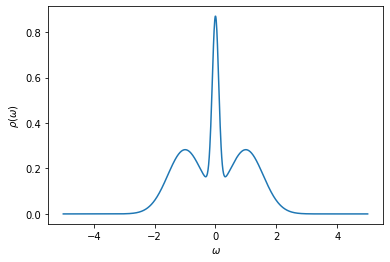

In [6]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

from scipy.integrate import quad
print(quad(rho, -10, 10))

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

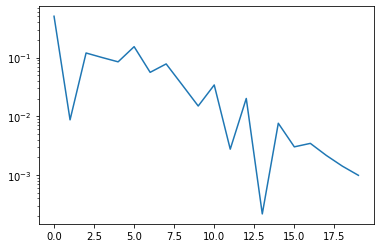

In [7]:
# Expand the spectral function in IR
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, -wmax, wmax)
all_l = np.arange(basis.s.size)

rhol = np.einsum('lw,w,w->l', basis.v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)
gl = - basis.s * rhol

plt.semilogy(np.abs(rhol)[::2])

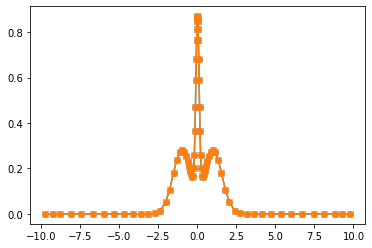

In [8]:
# Sampling points in the real-frequency space
def __oversample(x):
    xmid = 0.5*(x[1:] + x[:-1])
    return np.unique(np.hstack((x, xmid)))

def _oversample(x, n=1):
    for i in range(n):
        x = __oversample(x)
    return x

smpl_w = _oversample(basis.v[-1].roots(), 1)
prj_w = basis.v(smpl_w).T

plt.plot(smpl_w, rho(smpl_w), marker="x")
plt.plot(smpl_w, prj_w @ rhol, marker="o")

In [9]:
# Sum rule (from rhol)
prj_sum = basis.s * (basis.u(0) + basis.u(beta))
prj_sum = prj_sum.reshape((1,-1))
print(prj_sum.shape)
prj_sum @ rhol

(1, 40)


array([1.])

In [10]:
# Projector from sampled values to rho_l
prj_w_to_l = np.zeros((basis.size, smpl_w.size))

x_, w_ = leggauss(10)

for s in range(smpl_w.size-1):
    x, w = scale_quad(x_, w_, smpl_w[s], smpl_w[s+1])
    dx = smpl_w[s+1] - smpl_w[s]
    f = (x - smpl_w[s])/dx
    g = (smpl_w[s+1] - x)/dx
    for l in range(basis.size):
        prj_w_to_l[l, s+1] += np.sum(w * basis.v[l](x) * f)
        prj_w_to_l[l, s] += np.sum(w * basis.v[l](x) * g)

print("cond: ", np.linalg.cond(prj_w_to_l))

cond:  7.769177326018083


In [11]:
# w to l to sum
prj_sum_from_w = prj_sum @ prj_w_to_l
print(prj_sum_from_w.shape)
print(prj_sum_from_w @ rho(smpl_w))

(1, 77)
[1.00361337]


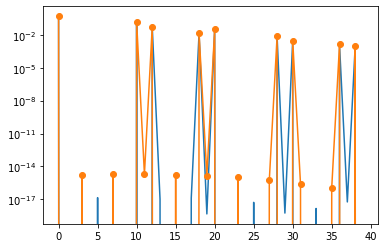

In [12]:
rho_l_ = prj_w_to_l @ rho(smpl_w)
plt.semilogy(rho_l_)
plt.semilogy(rhol, marker="o")

In [13]:
# rho_l = argmin_{x} |- s_l * x_l + g_l|_2^2 + alpha * |x|_1
alpha = 1e-10
noise = 1e-8
gl_dirty = gl + noise * np.random.randn(basis.size)

A = - basis.s[:,None] * prj_w_to_l

lstsq = ConstrainedLeastSquares(
          1.0, A, gl_dirty,
          prj_sum_from_w, np.array([1])
      )
l2 = L2Regularizer(alpha, smooth_regularizer_coeff(smpl_w))
nn = NonNegativePenalty(smpl_w.shape[0])

equality_conditions = [
      (0, 1, identity(smpl_w.size), identity(smpl_w.size)),
      (0, 2, identity(smpl_w.size), identity(smpl_w.size)),
]
problem = Problem([lstsq, l2, nn], equality_conditions)

In [14]:
x0 = None
opt = SimpleOptimizer(problem, x0=x0, mu=0.1)
opt.solve(10000)
prj_sum_from_w @ opt.x[0]

array([1.+0.j])

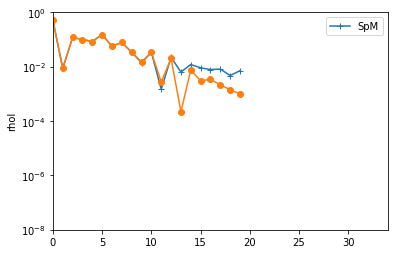

In [15]:
plt.semilogy(np.abs((prj_w_to_l@opt.x[0])[::2].real), marker="+", label="SpM")
plt.semilogy(np.abs(rhol[::2]), marker="o")
plt.xlim([0,34])
plt.ylim([1e-8,1])
plt.ylabel("rhol")
plt.legend()

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


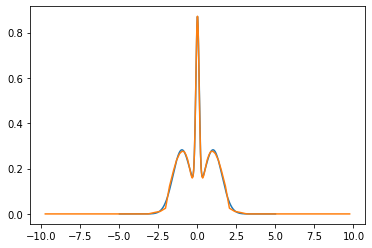

In [16]:
plt.plot(omegas, rho(omegas))
plt.plot(smpl_w, opt.x[0])

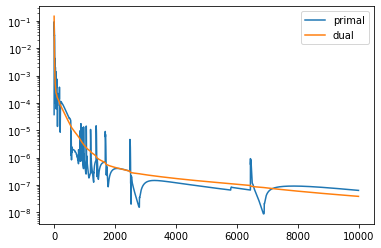

In [17]:
plt.semilogy(opt._primal_residual, label="primal")
plt.semilogy(opt._dual_residual, label="dual")
plt.legend()